# TD6 - Understanding gradient descent for multilayer perceptron

In the following notebook, we will cover error backpropagation and gradient descent in a multilayer perceptron **from scratch**.

The task we will try to solve is quite easy: Given a 2-dimensional variable vector $\mathbf{x} = (x_1, x_2)$, can be assign a binary class label (0 or 1) to each of the two vectors clusters?

We will start with moon-shaped clusters, but feel free to try out other types of distributions (you can find some of them in `sklearn.datasets`.)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import sklearn
import sklearn.datasets
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
#X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

y_train = y_train.reshape(-1, 1)

print(X.shape)
print(y.shape)
print(y)

(1000, 2)
(1000,)
[1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0
 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1
 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1
 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0
 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0
 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0
 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0
 1 0 0 

In [ ]:
# Rescale data (standardization)
train_mean = X_train.mean()
train_std = X_train.std()

print(train_mean)
print(train_std)

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

0.37964362633769544
0.7131687903021432


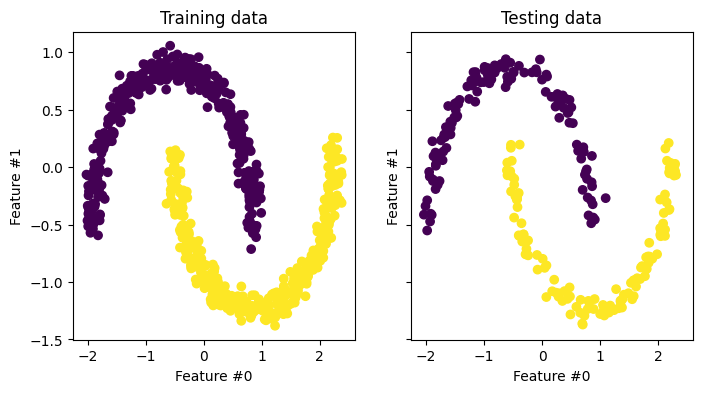

In [ ]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_ylabel("Feature #1")
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

## Linear transform, a.k.a. one-layer of neurons a.k.a. perceptron (without activation function)

First step on our journey is to define the simple operation of perceptron, without any activation function for now. We recall that a perceptron is doing:

$$y^m = \sum^n_i w^m_i x_i + b^m_i$$

for every input data vector $\mathrm{x}$ of dimension $n$, and for every neuron $m$. $y^m$ is the output of neuron $m$, $w^m$ are its synaptic weights (strenght of the connections between input and output), and $b^m$ are its bias weights.

This can be written as a matrix-vector product:

$$ \mathrm{y} = \mathrm{x} \cdot \mathrm{W} + \mathrm{b}$$

with $\mathrm{x} = (x_1, x_2, \dots x_n)$ and $\mathrm{y} = (y_1, y_2, \dots y_m)$. $\mathrm{W}$ is a matrix of shape $(n \times m)$ where $\mathrm{W}_{(i, j)}$ is the weight between input $i$ and neuron $j$. Similarly, $\mathrm{b} = (b_1, b_2 \dots b_m)$ contains bias weights of all outputs neurons.

### Initializer

We define a first function to initialize some connections between neurons with random weights and biases:

In [ ]:
def create_layer(input_shape, output_shape):
    """Create a layer of connections between neurons.

    Parameters:
    -----------
        input_shape : int
            Number of input neurons.
        output_shape : int
            Number of output neurons.

    Return
    ------
        array of shape (input_shape, output_shape),
        array of shape (output_shape, )
            w and b, the weights and biases between neurons.
    """
    # Create some uniformly distributed random weights using np.random.uniform
    w = np.random.uniform(0.0,1.0,input_shape*output_shape)
    b = np.random.uniform(0.0,1.0,input_shape*output_shape)
    return w, b

In [ ]:
w, b = create_layer(2, 3)
assert w.shape == (2, 3)
assert b.shape == (3, )

AssertionError: ignored

### Neural net operator

Then, we define a function that performs the neural network base operation defined above with some data, weights and biases:

In [ ]:
def linear(x, w, b):
    """A linear combination of inputs,
    a.k.a a perceptron with linear activation:

        y = x . w + b

    Parameters:
    -----------
        x : array of shape (n_samples, n)
            Input data.
        w : array of shape (n, m)
            Weight matrix.
        b : array of shape (m, )
            Bias vector.

    Return
    ------
        array of shape (n_samples, m)
            y, the output of the linear transformation.
    """
    # Using np.dot for "dot product" (scalar product)
    return ...

In [ ]:
x = [[0.5, 0.5]]
w = [[1.0], [1.0]]
b = [1.0]
y = linear(x, w, b)

assert y[0, 0] == np.array([2.0])

x = [[0.5, 0.5], [0.5, 0.5]]
w = [[1.0, 1.0], [1.0, 1.0]]
b = [1.0, 1.0]
y = linear(x, w, b)

assert y[0, 0] == 2.0
assert y[0, 1] == 2.0
assert y[1, 0] == 2.0
assert y[1, 1] == 2.0

### Derivative

Finally, because we will still need to compute gradients/derivatives of all operations in the neural network, we define its (very simple) derivative.

Note that we allow to take the derivative **with regard to the parameters $\mathrm{w}$ and $\mathrm{b}$**, because we eventually want to know **what is the effect of changing these parameters on the activity of the network, to find the best parameters.**

In [ ]:
def d_linear(x, w, b, with_regard_to="x"):
    """Gradient of the activity of the linear perceptron
    with regard to its parameters (weights and biases) or
    input (x).

    This is exactly like computing the derivative of an affine function,
    but with regard to any of the term in the function:

    y = x . w + b

    ->
        with regard to x:
            dy/dx = w (everything is considered constant except x)

        with regard to w:
            dy/dw = x (everything is considered constant except w)

        with regard to b:
            dy/db = 1 (everything is considered constant except b)

    Parameters
    ----------
        x : array of shape (n_samples, n)
            Input data.
        w : array of shape (n, m)
            Weight matrix.
        b : array of shape (m, )
            Bias vector.
        with_regard_to : "w", "x", "b"
            Take derivative/gradient from parameters w
            or b or from inputs x.

    Return
    ------
        array of shape (m, n) or (n, n_samples) or (1, n_samples)
            Derivative with regard to
    """
    if with_regard_to == "x":
        return w.T
    elif with_regard_to == "w":
        return x.T
    elif with_regard_to == "b":
        return np.ones((1, x.shape[0]))
    else:
        raise ValueError("'with_regard_to' must be equal to 'x', 'w' or 'b'.")

## Activation functions

Finally, we need to define activation functions and their derivatives. You may find the formula on internet.

### Tanh

In [ ]:
def tanh(x):
    """Hyperbolic tangent activation function tanh(x).

    Parameters
    ----------
        x : array

    Return
    ------
        array
    """
    # Simply using np.tanh
    return ...

def d_tanh(x):
    """Hyperbolic tangent derivative tanh'(x).

    Parameters
    ----------
        x : array

    Return
    ------
        array
    """
    # Also using np.tanh
    return ...

In [ ]:
x = np.linspace(-5, 5, 100)
plt.plot(x, tanh(x))
plt.plot(x, d_tanh(x))
plt.axhline(0.0, linestyle="--", alpha=0.5)
plt.axvline(0.0, linestyle="--", alpha=0.5)

### Sigmoid

In [ ]:
def sigmoid(x):
    """Sigmoid activation function σ(x)

    Parameters
    ----------
        x : array

    Return
    ------
        array
    """
    # Using np.exp
    return ...


def d_sigmoid(x):
    """Sigmoid derivative function σ'(x)

    Parameters
    ----------
        x : array

    Return
    ------
        array
    """
    # Using the previously defined sigmoid function
    return ...

In [ ]:
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x))
plt.plot(x, d_sigmoid(x))
plt.axhline(0.0, linestyle="--", alpha=0.5)
plt.axvline(0.0, linestyle="--", alpha=0.5)

## Loss functions

Given a prediction $\hat{y}$ (`y_pred` in the code) and a true value $y$ (`y_true` in the code), give **a measure of the distance or likelihood of the obtained prediction with regard to what we were expecting**.

We will cover two main loss functions, for regression and classification.

### Regression: Mean Squared Error

$$MSE(y,\hat{y}) = \frac{1}{2N} \sum^N_i(\hat{y}_i - y_i)^2$$

This is basically **the mean distance between $\hat{y}$ and $y$** (but squared, and divided by two for convenience when computing its derivative.)

$\rightarrow$ The shorter the distance, the better the fit.

In [ ]:
def mse(y_true, y_pred):
    """Mean Squared Error.

    Parameters
    ----------
        y_true : array of shape (n_samples, )
            Expected response of the model.
        y_pred : array of shape (n_samples, )
            Actual response of the model.

    Return
    ------
        array of shape (1, )
            MSE (square distance) of expected versus actual response.
    """
    # Using np.mean and '**2' to perform 'power(array, 2)'
    return ...

### Classification: Cross-entropy

Also called **negative log-likelihood** or **logistic loss** when performing binary classification.

In the binary case (only two classes):

$$
\mathcal{L}(\hat{y}, y) = - \frac{1}{N} \sum^N_i y_i \times \ln(\hat{y_i}) + (1 - y_i) \times \ln(1 - \hat{y_i})
$$

As we are estimating probabilities when doing classification (probability of being a cat or a dog, for instance), error can be computed as a **likelihood measure between probabilities distributions**.

Basically, we measure how good our model is at responding that:
- a cat is a cat, $y \times \ln(\hat{y})$, or how good is our estimation of $p$ in a binomial distribution of cats and not cats
- a dog is not a cat, $(1 - y) \times \ln(1 - \hat{y})$, or how good is our estimation of $1-p$ in a binomial distribution of cats and not cats.

$\rightarrow$ If the model is good at both, then **cross-entropy will reach 0**.

In [ ]:
def binary_crossentropy(y_true, y_pred):
    """Binary cross-entropy.

    Also known as negative log-likelihood or logistic loss.

    Parameters
    ----------
        y_true : array of shape (n_samples, )
            Expected response of the model.
        y_pred : array of shape (n_samples, )
            Actual response of the model.

    Return
    ------
        array of shape (1, )
            MSE (square distance) of expected versus actual response.
    """
    # Using np.log and np.mean (do not forget the leading minus sign !)
    return ...

### Bonus: general case with $C$ classes

In the general case with $C$ different classes (not only two):

$$
\mathcal{L}(\hat{y}, y) = - \frac{1}{N} \sum^N_i \sum_c^C y_i^c \times \ln(\hat{y_i^c})
$$

We will not cover this case for now, as our problem involves only two classes.
You can implement it as a bonus question.

In [ ]:
def crossentropy(y_true, y_pred):
    ...

### Derivatives

Finally, we need loss functions derivatives to perform gradient descent:

In [ ]:
def d_mse(y_true, y_pred):
    return  y_pred - y_true

def d_binary_crossentropy(y_true, y_pred):
    return np.divide(y_pred - y_true, y_pred * (1 - y_pred))

def d_crossentropy(y_true, y_pred):
    ...

## Visualizing the objective

The loss function chosen to evaluate our problem will define **the objective of our optimization process.** In other words, the loss will measure how well our model is predicting the data, and how much we should change model's parameters to make better prediction.

Machine learning techniques thus always aim at the same objective: **to find  parameters that make the loss (or error) as minimal as possible:**

$$ \underset{\theta}{\mathrm{argmin}}~~\mathcal{L}(\hat{y}=f(\theta, x), y) $$

with $f(\theta, x)$ as the result of our neural network, and parameters $\theta = \{\mathbf{w}, \mathbf{b}\}$ as all weights and biases in the network.

Given a simple one layer neural network (a perceptron) with bias $\mathrm{b} = 0$, with only two weights $w_1, w_2$, and with sigmoid activation function, let's have a look at what this loss function looks like in our case.

In [ ]:
def plot_surface(loss_values, w1, w2, view_init, loss_name, ax):

    min_index = np.unravel_index(np.argmin(loss_values), loss_values.shape)
    min_loss = loss_values[min_index]
    min_w1, min_w2 = w1[min_index[1]], w2[min_index[0]]

    ax.scatter(
        min_w1,
        min_w2,
        min_loss,
        c="red",
        s=100,
        label=f"Min. = {min_loss:.3f}"
        )

    ax.plot_surface(
        *np.meshgrid(w1, w2),
        loss_values,
        cmap="RdYlGn_r",
        alpha=0.5
        )

    ax.set_xlabel("$W_1$", size=20)
    ax.set_ylabel("$W_2$", size=20)
    ax.set_zlabel(loss_name, size=20, rotation="vertical")

    ax.view_init(*view_init)

    ax.legend()

    return ax


def plot_nonlinear_loss_landscape(x, y, param_range, steps):

    w1 = np.linspace(*param_range, steps)
    w2 = np.linspace(*param_range, steps)

    mse_values = np.zeros((steps, steps))
    crossentropy_values = np.zeros((steps, steps))
    for i in range(steps):
        for j in range(steps):

            w = np.array([[w1[i]], [w2[j]]])

            h = linear(x, w, 0)
            y_pred = sigmoid(h)

            mse_values[i, j] = mse(y, y_pred)
            crossentropy_values[i, j] = binary_crossentropy(y, y_pred)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15), subplot_kw={"projection": "3d"})

    plot_surface(mse_values, w1, w2, (30, 100), "MSE", ax1)
    plot_surface(crossentropy_values, w1, w2, (30, 100), "Bin. Crossentropy", ax2)

    plt.show()

In [ ]:
plot_nonlinear_loss_landscape(X_train, y_train, (-10, 10), 100)

As you noticed, this code is a bit long to execute. This is because we computed the loss value of our simple neural network **for 10,000 different combinations of parameter $w_1$ and $w_2$**, as shown on the plot.

This plot is of course impossible to build for real world applications: If there was more than 2 parameters in the model, this plot would have more than 4 dimensions. It would also take a very long time to create, as it requires to test all combinations of parameters.

This is why we use methods such as gradient descent to find the best values of parameters.

### Question: given these plots, what is the most appropriate loss function to use for our problem and why? What are the best parameters?

## First model: One layer neural network with sigmoid activation

The network is defined by two successive operations:

$$\mathbf{z} = \mathbf{x} \cdot \mathbf{W} + \mathbf{b}$$
$$\mathbf{y} = sigmoid(\mathbf{z})$$

All parameters are randomly initialized.

We will use cross-entropy as a loss function for this classification task.
The network will learn through gradient descent.

The algorithm can be cut in three main parts:

1. Make a prediction with current parameters $\mathbf{w, b}$. This is also called **the forward pass**, because information (the data here) goes from input of the model to its output.

$$\mathbf{z} = \mathbf{x} \cdot \mathbf{W} + \mathbf{b}$$
$$\mathbf{y} = sigmoid(\mathbf{z})$$

2. Compute error (loss) and compute the loss gradient with regard to all parameters of the model. This is also called **the backward pass**, because information (the error here) goes from output of the model to its input. It will inform us about the slope around the current parameters in the loss landscape (where is it going down and how fast ?)

$$\nabla_\mathbf{w} (\mathcal{L}) = \frac{\partial\mathcal{L}}{\partial \mathbf{y}} \times \frac{\partial \mathbf{y}}{\partial \mathbf{z}} \cdot \frac{\partial \mathbf{z}}{\partial \mathbf{w}}$$

$$\nabla_\mathbf{b} (\mathcal{L}) = \frac{\partial\mathcal{L}}{\partial \mathbf{y}} \times \frac{\partial \mathbf{y}}{\partial \mathbf{z}} \cdot \frac{\partial \mathbf{z}}{\partial \mathbf{b}}$$

3. Update parameters $\mathbf{w, b}$ using the gradient. This is called **gradient descent**. The parameter $\eta$ is called the learning rate, and controls how fast we jump from one position to another on the loss landscape, going down the slope (the gradient).

$$\mathbf{w} := \mathbf{w}-\eta \times \nabla_\mathbf{w} (\mathcal{L})$$
$$\mathbf{b} := \mathbf{b}-\eta \times \nabla_\mathbf{b} (\mathcal{L})$$


Doing so, we will slowly slide down the loss landscape we could see on the previous figures, until we reach a position close to the minimum point.

In [ ]:
input_shape = X_train.shape[1]  # X dimensions (here, 2)
output_shape = 1  # one neuron output

loss_values = []
y_preds = []
all_grad_w = []

all_w = []
all_b = []


#--- PARAMETERS and HYPERPARAMETERS ---

# some random weights to start with
w, b = create_layer(input_shape, output_shape)

# You can also try using some extreme values
# w = np.array([[-10], [10]])
# b = np.array([0])


# Number of epochs (iterations of gradient descent)
n_epochs = 100

# Learning rate
lr = 0.001

#--- TRAINING LOOP ---

for epoch in range(n_epochs):

    #--- PREDICTION (FORWARD PASS) ---

    #--- Layer 0: X_train ---
    # Nothing to do here, X_train virtually enters the network.


    #--- Layer 1 (input to output layer) ---
    # z = w . x + b
    z = ...
    # y = sigmoid(z)
    y = ...

    #--- Loss: L(y_true, y) ---
    loss = binary_crossentropy(y_train, y)

    y_preds.append(y)

    # Record everything before updating
    loss_values.append(loss)
    all_w.append(w)
    all_b.append(b)


    #--- BACK PROPAGATION (BACKWARD PASS) ---

    # All gradients and derivatives are marked
    # with "df/dx" notation.
    # Note that this is not rigorous for gradients
    # however.

    # dL/dy
    dL_dy = d_binary_crossentropy(y_train, y)

    # dL/dz = dL/dy * dy/dz
    dL_dz = ...

    # "dL/dw" (grad L/w) = grad z/w . dL/dz
    grad_z_w = d_linear(X_train, w, b, with_regard_to="w")
    grad_L_w = ...

    # "dL/db" (grad L/b) = grad z/b . dL/dz
    grad_z_b = d_linear(X_train, w, b, with_regard_to="b")
    grad_L_b = ...

    ##--- GRADIENT DESCENT ---

    w = w - ...
    b = b - ...

    all_grad_w.append(grad_L_w)

In [ ]:
plt.plot(loss_values)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
w1_values = np.linspace(-10, 10, 100)
w2_values = np.linspace(-10, 10, 100)

crossentropy_values = np.zeros((100, 100))
for i in range(100):
    for j in range(100):

        w = np.array([[w1_values[i]], [w2_values[j]]])

        h = linear(X_train, w, all_b[-1])
        y_pred = sigmoid(h)

        crossentropy_values[j, i] = binary_crossentropy(y_train, y_pred)

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")

plot_surface(crossentropy_values, w1_values, w2_values, (30, 30), "Bin. Crossentropy", ax1)

w1s = [ws[0] for ws in all_w]
w2s = [ws[1] for ws in all_w]

ax1.scatter(w1s, w2s, loss_values)

ax2 = fig.add_subplot(1, 2, 2)

grad_w1s = np.array([grad[0] for grad in all_grad_w])
grad_w2s = np.array([grad[1] for grad in all_grad_w])

ax2.contourf(*np.meshgrid(w1_values, w2_values), crossentropy_values, cmap="RdYlGn_r", levels=50, alpha=0.5)
quiver = ax2.quiver(w1s, w2s, -grad_w1s*lr, -grad_w2s*lr, scale=20)

ax2.set_title("Gradient update value ($-\\eta \\times \\nabla_{\\mathbf{w}}(\\mathcal{L})$)", size=20)
ax2.set_ylabel("$W_2$", size=20)
ax2.set_xlabel("$W_1$", size=20)

In [ ]:
x1 = np.linspace(-2.5, 2.5, 100)
x2 = np.linspace(-1.5, 1.5, 100)

X_grid = np.meshgrid(x1, x2)
X_grid = np.concatenate([X_grid[0].reshape(-1, 1), X_grid[1].reshape(-1, 1)], axis=1)

y = sigmoid(linear(X_grid, w, b))

y_pred = y.reshape(100, 100)

plt.contourf(*np.meshgrid(x1, x2), y_pred, cmap="coolwarm")
plt.colorbar(label="Sigmoid activation value")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.xlabel("Feature #0")
plt.ylabel("Feature #1")
plt.title("Output neuron activation for all data plane")
plt.show()

In [ ]:
def accuracy(y_pred, y_test, threshold=0.5):
    """Classification accuracy, with decision threshold.

    Parameters
    ----------
        y_pred : array
            Predictions (between 0 and 1)
        y_test : array
            Ground truth class values (0 or 1)
        threshold : float
            A threshold between 0 and 1. Predictions above the
            threshold will be interpreted as class 1, 0 otherwise.

    Return
    ------
        float
            Accuracy score.
    """
    y = y_pred.copy().squeeze()
    y[y > 0.5] = 1.0
    y[y <= 0.5] = 0.0
    return np.mean(y == y_test)

In [ ]:
# Apply model with w and b parameters on test data
y_pred = ...
print(f"Accuracy: {accuracy(y_pred, y_test, threshold=0.5) * 100}%")

### Question: conclude on the model's performance, and comment the plots.

### Question (bonus): change the training loop to perform mini batch stochastic gradient descent.

That means gradient is computed only on small "batches" (pieces) of data at a time. Dataset is randomly cut into small pieces at the begining of every epochs, and gradient descent is performed on every pieces (batches) of data during the epoch.

This adds a for-loop in the algorithm above:

```python
batch_size = 100 # max number of samples in a batch, for instance, 100

for epoch in epochs:

    batches = ... # randomly cut the dataset in batches of size batch_size

    for batch in batches:

        # forward, loss, backward and gradient descent on each batch.
```

## Second model: Multilayer perceptron (2 layers)

The network is now defined by four successive operations:

- Layer 1 (input to hidden layer):
$$\mathbf{z_1} = \mathbf{x} \cdot \mathbf{W_1} + \mathbf{b_1}$$
$$\mathbf{h} = \tanh(\mathbf{z_1})$$

- Layer 2 (hidden to output layer):
$$\mathbf{z_2} = \mathbf{h} \cdot \mathbf{W_2} + \mathbf{b_2}$$
$$\mathbf{y} = sigmoid(\mathbf{z_2})$$

As before, all parameters ($\mathbf{W_1},  \mathbf{b_1}, \mathbf{W_2}, \mathbf{b_2}$) are randomly initialized.

Gradient descent algorithm can be applied using the same equations as above, but with two more derivation steps:

- Gradient with regard to parameters of layer 2 (same as before):

$$\nabla_\mathbf{w_2} (\mathcal{L}) = \frac{\partial\mathcal{L}}{\partial \mathbf{y}} \times \frac{\partial \mathbf{y}}{\partial \mathbf{z_2}} \cdot \frac{\partial \mathbf{z_2}}{\partial \mathbf{w_2}}$$

$$\nabla_\mathbf{b_2} (\mathcal{L}) = \frac{\partial\mathcal{L}}{\partial \mathbf{y}} \times \frac{\partial \mathbf{y}}{\partial \mathbf{z_2}} \cdot \frac{\partial \mathbf{z_2}}{\partial \mathbf{b_2}}$$

- Gradient with regard to parameters of layer 1 (going one layer deeper than above):

$$\nabla_\mathbf{w_1} (\mathcal{L}) = \frac{\partial\mathcal{L}}{\partial \mathbf{y}} \times \frac{\partial \mathbf{y}}{\partial \mathbf{z_2}} \cdot \frac{\partial \mathbf{z_2}}{\partial \mathbf{h}} \times \frac{\partial \mathbf{h}}{\partial \mathbf{z_1}} \cdot \frac{\partial \mathbf{z_1}}{\partial \mathbf{w_1}} $$

$$\nabla_\mathbf{b_1} (\mathcal{L}) = \frac{\partial\mathcal{L}}{\partial \mathbf{y}} \times \frac{\partial \mathbf{y}}{\partial \mathbf{z_2}} \cdot \frac{\partial \mathbf{z_2}}{\partial \mathbf{h}} \times \frac{\partial \mathbf{h}}{\partial \mathbf{z_1}} \cdot \frac{\partial \mathbf{z_1}}{\partial \mathbf{b_1}} $$

In [ ]:
input_shape = X_train.shape[1]  # X dimensions (here, 2)
output_shape = 1  # one neuron output

loss_values = []
y_preds = []

#--- PARAMETERS and HYPERPARAMETERS ---

hidden_neurons = 3  # 3 hidden neurons

# some random weights to start with
w1, b1 = create_layer(input_shape, hidden_neurons)
w2, b2 = create_layer(hidden_neurons, output_shape)

# Number of epochs (iterations of gradient descent)
n_epochs = 500

# Learning rate
lr = 0.01

for epoch in range(n_epochs):

   #--- PREDICTION (FORWARD PASS) ---

    #--- Layer 0: X_train ---
    # Nothing to do here, X_train virtually enters the network.

    #--- Layer 1 (input to hidden layer) ---
    # z1 = w1 . x + b1
    z1 = ...
    # h = tanh(z1)
    h = ...

    #--- Layer 2 (hidden to output layer) ---
    # z2 = w2 . h + b2
    z2 = ...
    # y = sigmoid(z2)
    y = ...

    #--- Loss: L(y_true, y) ---
    loss = binary_crossentropy(y_train, y)

    y_preds.append(y)

    # Record loss before updating
    loss_values.append(loss)

    #--- BACK PROPAGATION (BACKWARD PASS) ---

    # All gradients and derivatives are marked
    # with "df/dx" notation.
    # Note that this is not rigorous for gradients
    # however.

    #--- Loss ---

    # dL/dy
    dL_dy = d_binary_crossentropy(y_train, y)

    #--- Layer 2 ---

    # dL/dz2 = dL/dy * dy/dz2
    dL_dz2 = ...

    # "dL/dw2" (grad L/w2) = grad z2/w2 . dL/dz2
    grad_z2_w2 = ...
    grad_L_w2 = ...

    # "dL/db2" (grad L/b2) = grad z2/b2 . dL/dz2
    grad_z2_b2 = ...
    grad_L_b2 = ...

    #--- Layer 1 ---

    # dL/dh = dL/dz2 . dz2/dh
    dz2_dh = ...
    dL_dh = ...

    # dL/dz1 = dL/dh * dh/dz1
    dL_dz1 = ...

    # "dL/dw1" (grad L/w1) = grad z1/w1 . dL/dz1
    grad_z1_w1 = ...
    grad_L_w1 = ...

    # "dL/db1" (grad L/b1) = grad z1/b1 . dL/dz1
    grad_z1_b1 = ...
    grad_L_b1 = ...


    ##--- GRADIENT DESCENT ---

    ...

In [ ]:
plt.plot(loss_values)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
x1 = np.linspace(-2.5, 2.5, 100)
x2 = np.linspace(-1.5, 1.5, 100)

X_grid = np.meshgrid(x1, x2)
X_grid = np.concatenate([X_grid[0].reshape(-1, 1), X_grid[1].reshape(-1, 1)], axis=1)

h = tanh(linear(X_grid, w1, b1))
y_pred = sigmoid(linear(h, w2, b2))

y_pred = y_pred.reshape(100, 100)

plt.contourf(*np.meshgrid(x1, x2), y_pred, cmap="coolwarm")
plt.colorbar(label="Sigmoid activation value")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.xlabel("Feature #0")
plt.ylabel("Feature #1")
plt.title("Output neuron activation for all data plane")
plt.show()

In [ ]:
# Apply model with w1, b1, w2 and b2 parameters on test data
y_pred = ...
print(f"Accuracy: {accuracy(y_pred, y_test, threshold=0.5) * 100}%")

## Going further: Make it clean, make it re-usable

Now that we have defined the building blocks of any simple feed-forward multilayered neural network, let's pack it up into a nice Object Oriented code, using Python classes.

### The `Layer` class

A `Layer` applies one step of operation (like the linear transform or the activation function) on data of shape `(n_samples, n_features)`.

It can also store some parameters (like $\mathbf{w}$ and $\mathbf{b}$), and compute its own gradient with regard to its parameters or to some inputs.

### A note on Python classes

They work exactly like C# classes. You can declare attributes and methods, create abstract classes, etc.

A class constructor is always called `__init__`. It can accepts any kind of parameters. It is not mandatory to declare it (if you have no parameters to pass at construction of the instance, you can always create objects by calling the class like this: `Layer()`.).

All methods (including `__init__`) must take as first parameter `self`. `self` behaves exactly like `this` in C#, but is mandatory within a class in Python as soon as you use an attribute or a method of the class.

Inheritance from a class is declared with `class B(A)`, which means that class `B` inherits from class `A`.

In [ ]:
# Base abstract class
class Layer:

    def __init__(self):

        # Will store all data that enters the layer
        # (necessary to compute the gradient)
        self.inputs = None

    def forward(self, x):
        """Forward pass"""
        raise NotImplementedError

    def backward(self, x, dL):
        """Backward pass (backpropagation)"""
        raise NotImplementedError

    def update(self, lr):
        """Parameter update (gradient descent), if any. Else, just pass."""
        pass

### Dense layer

This layer defines weights and biases between neurons and applies a linear transform.

Its two main methods (`forward` and `backward`) implements both forward an backward path in a composable way: They can be chained to any other layer.

#### Forward pass

`forward` method implements the following mechanism, for any layer $l$ in the network:

$$\mathbf{z}^{(l)} = \mathbf{x}^{(l-1)} \cdot \mathbf{W}^{(l)} + \mathbf{b}^{(l)}$$

where $\mathbf{x}^{(l-1)}$ are the previous layer $l-1$ outputs (or the network inputs $\mathbf{x}$ if $l$ is the first layer).

Hence, `dense2.forward(dense1.forward(dense0.forward(x)))` would yield the output of a 3-layers perceptron (without activation function).

In the following code, we will refer to $\mathbf{x}^{(l-1)}$ using the `x` parameter in the `forward` function, meaning any kind of input entering the layer (from a previous layer or not).

#### Backward pass

Similarly, we can compute gradients in a composable way using the `backward` method.

You may already have noticed that the more layers we add, the more we repeat the same operations during backpropagation. Let's consider we do not have any activation function for now in our network (adding them won't add to much complexity though):

- Gradient with regard to parameters of layer $n$ (top layer):

$$\nabla_\mathbf{w_n} (\mathcal{L}) = \frac{\partial\mathcal{L}}{\partial \mathbf{y}} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{w_n}}$$

$$\nabla_\mathbf{b_n} (\mathcal{L}) = \frac{\partial\mathcal{L}}{\partial \mathbf{y}} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{b_n}}$$

- Gradient with regard to inputs of layer $n$ (top layer), which are $z_{n-1}$, the outputs of layer $n-1$:

$$\nabla_\mathbf{z_{n-1}} (\mathcal{L}) = \frac{\partial\mathcal{L}}{\partial \mathbf{y}} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{z_{n-1}}}$$

We can therefore express gradient with regard to parameters of layer $n-1$ (one layer before) as:

$$\nabla_\mathbf{w_{n-1}} (\mathcal{L}) = \nabla_\mathbf{z_{n-1}} (\mathcal{L}) \cdot \frac{\partial \mathbf{z_{n-1}}}{\partial \mathbf{w_{n-1}}} $$

$$\nabla_\mathbf{b_{n-1}} (\mathcal{L}) = \nabla_\mathbf{z_{n-1}} (\mathcal{L}) \cdot \frac{\partial \mathbf{z_{n-1}}}{\partial \mathbf{b_{n-1}}} $$

In fact, we just need every layer $n-1$ `backward` function to take as parameter the previously computed gradient $\nabla_\mathbf{z_{n-1}} (\mathcal{L})$, to store the gradients it needs for the update step ($\nabla_\mathbf{w_{n-1}} (\mathcal{L})$ and $\nabla_\mathbf{b_{n-1}} (\mathcal{L})$) and to return the gradient for the next layer $n-2$, $\nabla_\mathbf{z_{n-2}} (\mathcal{L})$.

Hence, `dense0.backward(dense1.backward(dense2.backward(d_loss)))` would yield the gradients of a 3-layers perceptron (without activation function), given the loss gradient `d_loss` (notice how the order of the layer is inverted compared to the `forward` function).

In the next code, we will refer to $\nabla_\mathbf{z_{n-1}} (\mathcal{L})$ using the `dL` parameter of the backward function (roughly meaning "the derivative of error coming from the loss and layers above").

In [ ]:
class Dense(Layer):

    def __init__(self, input_shape, output_shape):
        super().__init__()  # call parent class constructor
        # Now, self.inputs exists.

        self.w, self.b = create_layer(input_shape, output_shape)

        # gradients will be stored here between backward and update
        self.grad_w = None
        self.grad_b = None

    def forward(self, x):
        h = ...
        self.inputs = x  # store inputs for gradient computation
        return h

    def backward(self, dL):

        # compute all possible gradients
        grad_z_w = d_linear(self.inputs, self.w, self.b, with_regard_to="w")
        grad_z_b = d_linear(self.inputs, self.w, self.b, with_regard_to="b")
        grad_z_x = d_linear(self.inputs, self.w, self.b, with_regard_to="x")

        # store gradients needed for update
        self.grad_w = ...
        self.grad_b = ...

        # return error gradient for propagation to previous layers
        return np.dot(dL, grad_z_x)

    def update(self, lr):
        self.w = ...
        self.b = ...

### Sigmoid and Tanh layers

These layers apply some activation function of data.

We define their `forward` and `backward` function is a similar way as for the `Dense` layer. `forward` applies the function on any inputs `x` (for instance, outputs from a previous layer). `backward` computes gradients with regard to the inputs of the function and the previously accumulated gradient `dL`. This is overall the exact same operations as in the training loop defined earlier.

In [ ]:
class Tanh(Layer):

    def forward(self, x):
        ...

    def backward(self, dL):
        ...

In [ ]:
class Sigmoid(Layer):

    def forward(self, x):
        ...

    def backward(self, dL):
        ...

### The `Model` class

This class will hold all layers in one place, and perform the full forward,backward, and update steps.

Now that we have defined our layers in a way that we can compose them, let's create a final class that will hold everything together. The forward pass of a `Model` is now just the succession of foward operations of all layers in that `Model`, from first layer to last, given some input data.

Similarly, the backward pass is the succession of backward operations of all layers from last to first, given some loss gradient.

Both computations can be performed within simple for-loops iterating over the layers list:

```python
# Forward pass of whole model
for layer in layers:
    y = layer(x)
    x = y  # pass output to next layer
```

```python
# Backward pass of whole model

# reverse layers now, to go from top to bottom layers!
for layer in reversed(layers):
    dL_next = layer(dL)
    dL = dL_next  # pass gradient to previous layer
```



In [ ]:
class Model:

    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):

        # Call all layers one after the other,
        # from bottom layers to top layers.
        ...

        return y

    def backward(self, dL):

        # Pass gradient from top layers to bottom layers.
        for layer in reversed(self.layers): # reverse layer order
            ...

    def update(self, lr):

        for layer in self.layers:
            layer.update(lr)

In [ ]:
# Create a n layer perceptron (2 to begin with)
model = ...

In [ ]:
# Training loop with the model object
n_epochs = 100
lr = 0.01
loss_values = []

for epoch in range(n_epochs):

    # Forward pass
    y_pred = ...

    # Loss
    loss = ...
    loss_values.append(loss)

    # Loss gradient
    dL = ...

    # Backward pass
    ...

    # Parameters update
    ...

In [ ]:
plt.plot(loss_values)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
x1 = np.linspace(-2.5, 2.5, 100)
x2 = np.linspace(-1.5, 1.5, 100)

X_grid = np.meshgrid(x1, x2)
X_grid = np.concatenate([X_grid[0].reshape(-1, 1), X_grid[1].reshape(-1, 1)], axis=1)

# Calling the whole network is much easier now!
y_pred = model.forward(X_grid)

y_pred = y_pred.reshape(100, 100)

plt.contourf(*np.meshgrid(x1, x2), y_pred, cmap="coolwarm")
plt.colorbar(label="Sigmoid activation value")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.xlabel("Feature #0")
plt.ylabel("Feature #1")
plt.title("Output neuron activation for all data plane")
plt.show()

In [ ]:
# Apply model forward method to make predictions on test data
y_pred = ...
print(f"Accuracy: {accuracy(y_pred, y_test, threshold=0.5) * 100}%")

### Question (bonus): Apply your `Model` on more complex datasets (like we did in other TDs).

For instance, go back to the Titanic or Fashion-MNIST datasets and try you own tools on it (you may need to create new activation functions like softmax and new losses! cf. Crossentropy section)

### Question (bonus): Make a visualization of what is happening in the first layer of your two layered perceptron (maybe we can look at the loss landscape for a couple parameters only ?) Try to spot the local minima.